In [1]:
import datetime
from sys import stdout
import time

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from func.tide import get_dates
from tech.psar import (
    calc_PSAR,
    calc_PSAR0,
    initialize,
)

### 収集対象の日

In [19]:
target='2024-12-30'
start, end = get_dates(target)

### 対象銘柄

In [20]:
code = '8306'

### yfinance で１分足のデータを収集

In [21]:
symbol = '%s.T' % code
ticker = yf.Ticker(symbol)

df = ticker.history(period='1d', interval='1m', start=start, end=end)
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2024-12-30 09:00:00+09:00,1845.0,1851.5,1843.5,1849.0,0,0.0,0.0
2024-12-30 09:01:00+09:00,1849.5,1851.5,1846.0,1847.0,504800,0.0,0.0
2024-12-30 09:02:00+09:00,1847.5,1853.0,1847.0,1853.0,668100,0.0,0.0
2024-12-30 09:03:00+09:00,1853.0,1859.5,1852.5,1858.0,1141400,0.0,0.0
2024-12-30 09:04:00+09:00,1858.5,1858.5,1849.5,1853.0,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-12-30 15:20:00+09:00,1845.5,1846.0,1845.0,1845.0,184400,0.0,0.0
2024-12-30 15:21:00+09:00,1844.5,1844.5,1843.5,1844.0,90300,0.0,0.0
2024-12-30 15:22:00+09:00,1844.0,1844.0,1843.0,1843.0,97300,0.0,0.0


### 時間情報のタイムゾーン部分を削除

In [22]:
name_index = df.index.name
df.index = [ts_jst.tz_localize(None) for ts_jst in df.index]
df.index.name = name_index
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2024-12-30 09:00:00,1845.0,1851.5,1843.5,1849.0,0,0.0,0.0
2024-12-30 09:01:00,1849.5,1851.5,1846.0,1847.0,504800,0.0,0.0
2024-12-30 09:02:00,1847.5,1853.0,1847.0,1853.0,668100,0.0,0.0
2024-12-30 09:03:00,1853.0,1859.5,1852.5,1858.0,1141400,0.0,0.0
2024-12-30 09:04:00,1858.5,1858.5,1849.5,1853.0,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-12-30 15:20:00,1845.5,1846.0,1845.0,1845.0,184400,0.0,0.0
2024-12-30 15:21:00,1844.5,1844.5,1843.5,1844.0,90300,0.0,0.0
2024-12-30 15:22:00,1844.0,1844.0,1843.0,1843.0,97300,0.0,0.0


### 前場と後場の間に（なぜか）余分なデータが含まれているので削除

In [23]:
date_str = str(df.index[0].date())
dt_lunch_1 = pd.to_datetime('%s 11:30:00' % date_str)
dt_lunch_2 = pd.to_datetime('%s 12:30:00' % date_str)
df1 = df[df.index <= dt_lunch_1]
df2 = df[dt_lunch_2 <= df.index]
df = pd.concat([df1, df2])
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2024-12-30 09:00:00,1845.0,1851.5,1843.5,1849.0,0,0.0,0.0
2024-12-30 09:01:00,1849.5,1851.5,1846.0,1847.0,504800,0.0,0.0
2024-12-30 09:02:00,1847.5,1853.0,1847.0,1853.0,668100,0.0,0.0
2024-12-30 09:03:00,1853.0,1859.5,1852.5,1858.0,1141400,0.0,0.0
2024-12-30 09:04:00,1858.5,1858.5,1849.5,1853.0,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-12-30 15:20:00,1845.5,1846.0,1845.0,1845.0,184400,0.0,0.0
2024-12-30 15:21:00,1844.5,1844.5,1843.5,1844.0,90300,0.0,0.0
2024-12-30 15:22:00,1844.0,1844.0,1843.0,1843.0,97300,0.0,0.0


### Parabolic SAR の算出（一行ずつ）

In [24]:
df = initialize(df)
for i in range(len(df)):
    if i == 1:
        calc_PSAR0(df, i)
    elif i > 1:
        calc_PSAR(df, i)
print(df)

                       Open    High     Low   Close   Volume  Trend      EP  \
Datetime                                                                      
2024-12-30 09:00:00  1845.0  1851.5  1843.5  1849.0        0    NaN     NaN   
2024-12-30 09:01:00  1849.5  1851.5  1846.0  1847.0   504800   -1.0  1846.0   
2024-12-30 09:02:00  1847.5  1853.0  1847.0  1853.0   668100    1.0  1853.0   
2024-12-30 09:03:00  1853.0  1859.5  1852.5  1858.0  1141400    1.0  1859.5   
2024-12-30 09:04:00  1858.5  1858.5  1849.5  1853.0        0    1.0  1859.5   
...                     ...     ...     ...     ...      ...    ...     ...   
2024-12-30 15:20:00  1845.5  1846.0  1845.0  1845.0   184400    1.0  1847.0   
2024-12-30 15:21:00  1844.5  1844.5  1843.5  1844.0    90300   -1.0  1843.5   
2024-12-30 15:22:00  1844.0  1844.0  1843.0  1843.0    97300   -1.0  1843.0   
2024-12-30 15:23:00  1843.0  1844.5  1843.0  1843.5   177300   -1.0  1843.0   
2024-12-30 15:24:00  1844.0  1844.5  1843.5  1844.0 

### プロットしやすいように bull と bear を分ける

In [25]:
df['bull'] = df[df['Trend'] == 1]['PSAR']
df['bear'] = df[df['Trend'] == -1]['PSAR']
df

,Open,High,Low,Close,Volume,Trend,EP,AF,PSAR,bull,bear
Datetime,,,,,,,,,,,
2024-12-30 09:00:00,1845.0,1851.5,1843.5,1849.0,0,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-30 09:01:00,1849.5,1851.5,1846.0,1847.0,504800,-1.0,1846.0,0.02,1846.000000,NaN,1846.000000
2024-12-30 09:02:00,1847.5,1853.0,1847.0,1853.0,668100,1.0,1853.0,0.02,1846.000000,1846.000000,NaN
2024-12-30 09:03:00,1853.0,1859.5,1852.5,1858.0,1141400,1.0,1859.5,0.04,1846.540000,1846.540000,NaN
2024-12-30 09:04:00,1858.5,1858.5,1849.5,1853.0,0,1.0,1859.5,0.04,1847.058400,1847.058400,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 15:20:00,1845.5,1846.0,1845.0,1845.0,184400,1.0,1847.0,0.04,1844.876634,1844.876634,NaN
2024-12-30 15:21:00,1844.5,1844.5,1843.5,1844.0,90300,-1.0,1843.5,0.02,1847.000000,NaN,1847.000000
2024-12-30 15:22:00,1844.0,1844.0,1843.0,1843.0,97300,-1.0,1843.0,0.04,1846.840000,NaN,1846.840000


### １分足のローソク足チャートに PSAR をプロット

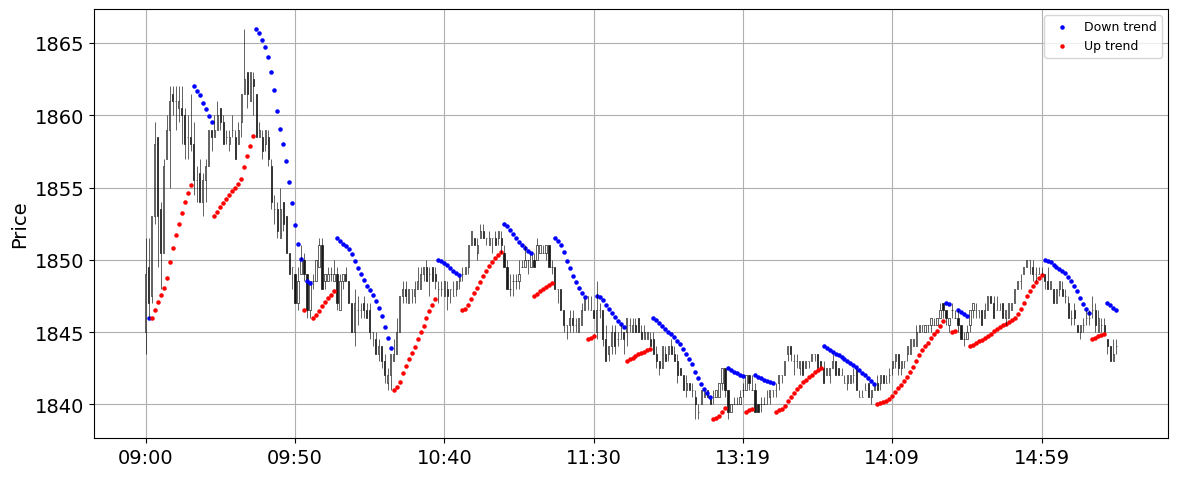

In [26]:
plt.rcParams["font.size"] = 14
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        df['bear'],
        type='scatter',
        marker='o',
        markersize=5,
        color='blue',
        label='Down trend',
        ax=ax
    ),
    mpf.make_addplot(
        df['bull'],
        type='scatter',
        marker='o',
        markersize=5,
        color='red',
        label='Up trend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    volume=False,
    datetime_format='%H:%M',
    addplot=apds,
    xrotation=0,
    ax=ax,
)

ax.grid()
ax.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.show()

### ティックデータを読み込み、インデックスの形式を OHLC データと揃える

In [27]:
name_tick = 'tick/%s_%s_rt.csv' % (code, target)
df0 = pd.read_csv(name_tick)
t_index = [pd.to_datetime('%s %s' % (date_str, t)) for t in df0['時刻']]

In [28]:
df_tick = pd.DataFrame({'Price': list(df0['株価'])}, index=t_index)
df_tick.index.name='Datetime'
df_tick

,Price
Datetime,
2024-12-30 09:00:00,1848.5
2024-12-30 09:00:02,1846.5
2024-12-30 09:00:04,1845.0
2024-12-30 09:00:05,1846.0
2024-12-30 09:00:08,1847.0
...,...
2024-12-30 15:24:40,1844.0
2024-12-30 15:24:42,1843.5
2024-12-30 15:24:44,1844.0


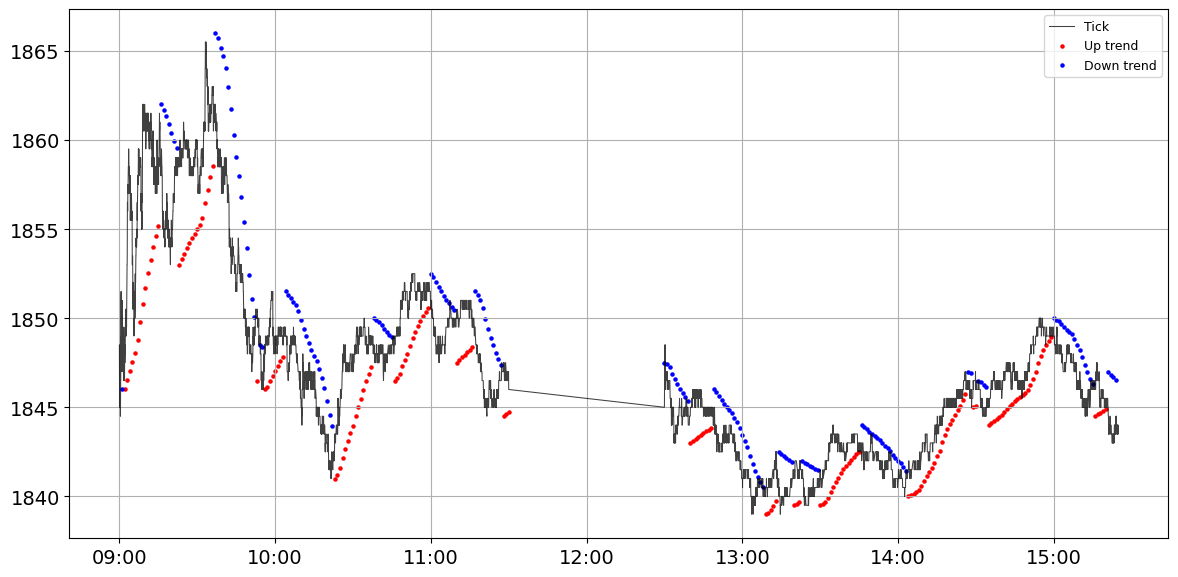

In [29]:
plt.rcParams["font.size"] = 14
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

ax.plot(df_tick, lw=0.75, color='black', alpha=0.75, label='Tick')
ax.scatter(df.index, df['bull'], marker='o', s=5, color='red', label='Up trend',)
ax.scatter(df.index, df['bear'], marker='o', s=5, color='blue', label='Down trend',)

formatter = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(formatter)

ax.grid()
ax.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.show()

## 売買シミュレーション

### 取引時間

In [30]:
MKT_START = pd.to_datetime('%s 09:00:00' % date_str)
MKT_CLOSE = pd.to_datetime('%s 15:24:50' % date_str)
SECOND = datetime.timedelta(seconds=1)
MINUTE = datetime.timedelta(minutes=1)

### 取引クラス

In [31]:
class Trader:
    def __init__(self):
        self.trend = 0
        self.unit = 100
        self.price = 0
        self.position = '無し'
        self.total = 0


    def doRepayment(self, t, price: float):
        if self.position == '買掛':
            action = '売埋'
            sign = +1
        elif self.position == '売掛':
            sign = -1
            action = '買埋'
        else:
            sign = 0
            action = '不明'

        profit = (price - self.price) * self.unit * sign
        self.total += profit
        self.price = 0
        print(t, price * self.unit, action, profit)

    
    def setPosition(self, t, trend: int, price: float):
        if trend == +1:
            self.position = '買掛'
        elif trend == -1:
            self.position = '売掛'
        else:
            self.position = '無し'
        self.price = price
        print(t, self.price * self.unit, self.position)

    def getProfit(self, price):
        if self.price == 0:
            return 0

        if self.position == '買掛':
            sign = +1
        elif self.position == '売掛':
            sign = -1
        else:
            sign = 0

        return (price - self.price) * self.unit * sign

### シミュレーション

In [32]:
# 初期化
trader = Trader()
t = MKT_START
trend = 0
price_current = 0
df_profit = pd.DataFrame()

# シミュレーション（ループ）
while t < MKT_CLOSE:
    # １分足データからトレンドを確認
    if t.second == 0:
        # OHLC が確定しているのは１分前
        t0 = t - MINUTE
        if t0 in df.index:
            trend = df.loc[t0, 'Trend']

    # ティックデータ
    if t in df_tick.index:
        price_current = df_tick.loc[t, 'Price']

    if price_current > 0:
        if np.isnan(trend):
            pass
        elif not np.isnan(trend) and trader.trend == 0:
            trader.trend = trend
        elif trader.trend != trend:
            # トレンド変換
            if trader.price > 0:
                trader.doRepayment(t, price_current)
            trader.trend = trend
            if trader.price == 0:
                trader.setPosition(t, trend, price_current)

    if price_current > 0:
        df_profit.loc[t, 'Profit'] = trader.getProfit(price_current)
    else:
        df_profit.loc[t, 'Profit'] = 0
    
    t += SECOND


trader.doRepayment(t, price_current)
#stdout.write('\n')
print('Total profit', trader.total)

2024-12-30 09:03:00 185300.0 買掛
2024-12-30 09:17:00 185550.0 売埋 250.0
2024-12-30 09:17:00 185550.0 売掛
2024-12-30 09:24:00 185950.0 買埋 -400.0
2024-12-30 09:24:00 185950.0 買掛
2024-12-30 09:38:00 185900.0 売埋 -50.0
2024-12-30 09:38:00 185900.0 売掛
2024-12-30 09:54:00 184900.0 買埋 1000.0
2024-12-30 09:54:00 184900.0 買掛
2024-12-30 09:55:00 184650.0 売埋 -250.0
2024-12-30 09:55:00 184650.0 売掛
2024-12-30 09:57:00 184850.0 買埋 -200.0
2024-12-30 09:57:00 184850.0 買掛
2024-12-30 10:05:00 184650.0 売埋 -200.0
2024-12-30 10:05:00 184650.0 売掛
2024-12-30 10:24:00 184350.0 買埋 300.0
2024-12-30 10:24:00 184350.0 買掛
2024-12-30 10:39:00 184800.0 売埋 450.0
2024-12-30 10:39:00 184800.0 売掛
2024-12-30 10:47:00 184900.0 買埋 -100.0
2024-12-30 10:47:00 184900.0 買掛
2024-12-30 11:01:00 185000.0 売埋 100.0
2024-12-30 11:01:00 185000.0 売掛
2024-12-30 11:11:00 184950.0 買埋 50.0
2024-12-30 11:11:00 184950.0 買掛
2024-12-30 11:18:00 184800.0 売埋 -150.0
2024-12-30 11:18:00 184800.0 売掛
2024-12-30 11:29:00 184700.0 買埋 100.0
2024-12-30 11:

In [33]:
df_profit

,Profit
2024-12-30 09:00:00,0.0
2024-12-30 09:00:01,0.0
2024-12-30 09:00:02,0.0
2024-12-30 09:00:03,0.0
2024-12-30 09:00:04,0.0
...,...
2024-12-30 15:24:45,-0.0
2024-12-30 15:24:46,-0.0
2024-12-30 15:24:47,-0.0
2024-12-30 15:24:48,50.0


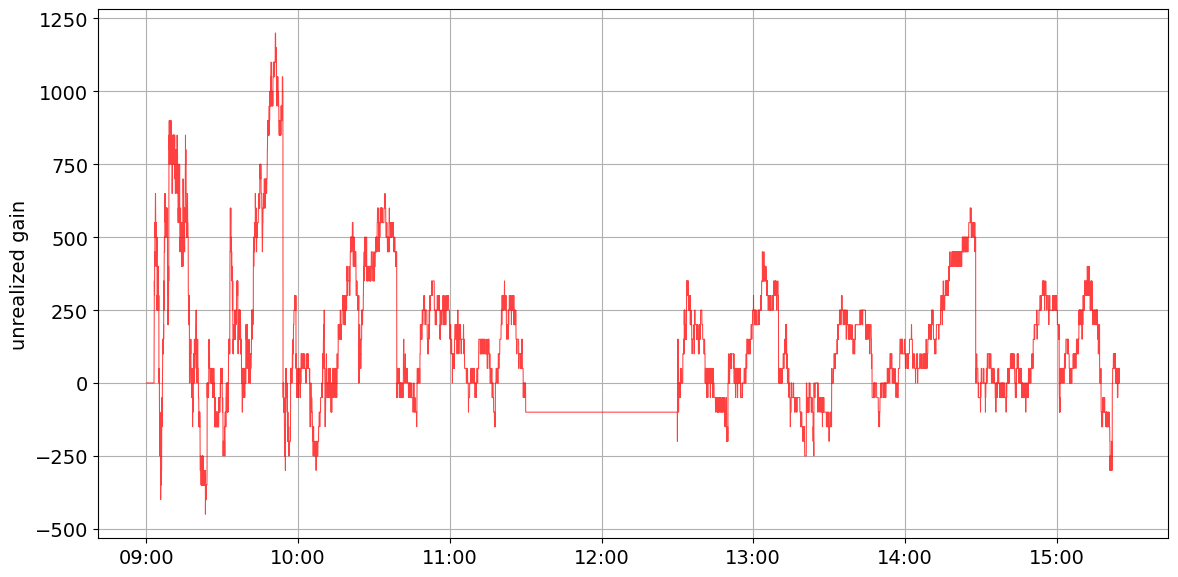

In [34]:
plt.rcParams["font.size"] = 14
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

ax.plot(df_profit.index, df_profit['Profit'], lw=0.75, color='red', alpha=0.75)
ax.set_ylabel('unrealized gain')

formatter = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(formatter)

ax.grid()

plt.tight_layout()
plt.show()